In [1]:
from openpiv.pyprocess import get_field_shape, vectorized_correlation_to_displacements, fft_correlate_images
from openpiv.validation import local_median_val
from openpiv.tools import imread
from matplotlib import pyplot as plt
import numpy as np

In [2]:
def get_coordinates(image_size, search_area_size, overlap, center_on_field = True):
    """Compute the x, y coordinates of the centers of the interrogation windows.
    the origin (0,0) is like in the image, top left corner
    positive x is an increasing column index from left to right
    positive y is increasing row index, from top to bottom


    Parameters
    ----------
    image_size: two elements tuple
        a two dimensional tuple for the pixel size of the image
        first element is number of rows, second element is
        the number of columns.

    search_area_size: int
        the size of the search area windows, sometimes it's equal to
        the interrogation window size in both frames A and B

    overlap: int = 0 (default is no overlap)
        the number of pixel by which two adjacent interrogation
        windows overlap.


    Returns
    -------
    x : 2d np.ndarray
        a two dimensional array containing the x coordinates of the
        interrogation window centers, in pixels.

    y : 2d np.ndarray
        a two dimensional array containing the y coordinates of the
        interrogation window centers, in pixels.

        Coordinate system 0,0 is at the top left corner, positive
        x to the right, positive y from top downwards, i.e.
        image coordinate system

    """

    # get shape of the resulting flow field
    field_shape = get_field_shape(image_size,
                                  search_area_size,
                                  overlap)

    # compute grid coordinates of the search area window centers
    # note the field_shape[1] (columns) for x
    x = (
        np.arange(field_shape[1]) * (search_area_size - overlap)
        + (search_area_size) / 2.0
    )
    # note the rows in field_shape[0]
    y = (
        np.arange(field_shape[0]) * (search_area_size - overlap)
        + (search_area_size) / 2.0
    )

    # moving coordinates further to the center, so that the points at the
    # extreme left/right or top/bottom
    # have the same distance to the window edges. For simplicity only integer
    # movements are allowed.
    if center_on_field == True:
        x += (
            image_size[1]
            - 1
            - ((field_shape[1] - 1) * (search_area_size - overlap) +
                (search_area_size - 1))
        ) // 2
        y += (
            image_size[0] - 1
            - ((field_shape[0] - 1) * (search_area_size - overlap) +
               (search_area_size - 1))
        ) // 2

        # the origin 0,0 is at top left
        # the units are pixels

    return np.meshgrid(x, y)

In [3]:
def get_rect_coordinates(frame_a, window_size, overlap, center_on_field = False):
    '''
    Rectangular grid version of get_coordinates.
    '''
    if isinstance(window_size, tuple) == False and isinstance(window_size, list) == False:
        window_size = [window_size, window_size]
    if isinstance(overlap, tuple) == False and isinstance(overlap, list) == False:
        overlap = [overlap, overlap]
    _, y = get_coordinates(frame_a, window_size[0], overlap[0], center_on_field = False)
    x, _ = get_coordinates(frame_a, window_size[1], overlap[1], center_on_field = False)
    return np.meshgrid(x[0,:], y[:,0])

In [4]:
def sliding_window_array(image, window_size = 64, overlap = 32):
    '''
    Basically, we have a 2d array and we want to perform cross-correlation
    over the interrogation windows. An approach could be to loop over the array
    but loops are expensive in python. So we create from the array a new array
    with three dimension, of size (n_windows, window_size, window_size), in
    which each slice, (along the first axis) is an interrogation window.
    '''
    if isinstance(window_size, tuple) == False and isinstance(window_size, list) == False:
        window_size = [window_size, window_size]
    if isinstance(overlap, tuple) == False and isinstance(overlap, list) == False:
        overlap = [overlap, overlap]

    x, y = get_rect_coordinates(image.shape, window_size, overlap, center_on_field = False)
    x = (x - window_size[1]//2).astype(int); y = (y - window_size[0]//2).astype(int)
    x, y = np.reshape(x, (-1,1,1)), np.reshape(y, (-1,1,1))

    win_x, win_y = np.meshgrid(np.arange(0, window_size[1]), np.arange(0, window_size[0]))
    win_x = win_x[np.newaxis,:,:] + x
    win_y = win_y[np.newaxis,:,:] + y
    windows = image[win_y, win_x]
    
    return windows

In [5]:
def piv(frame_a, frame_b, window_size, overlap):
    n_rows, n_cols = get_field_shape(
        frame_a.shape, 
        window_size,
        overlap
    )
    x, y = get_rect_coordinates(frame_a.shape, window_size, overlap, center_on_field = False)

    aa = sliding_window_array(
                frame_a, 
                window_size, 
                overlap
    )
    bb = sliding_window_array(
                frame_b, 
                window_size,
                overlap
    )
    corr = fft_correlate_images(
                aa, bb,
                correlation_method='circular',
                normalized_correlation = True
    )
    u, v = vectorized_correlation_to_displacements(
        corr, 
        n_rows,
        n_cols,
        subpixel_method='gaussian'
    )
    return x, y, u, v

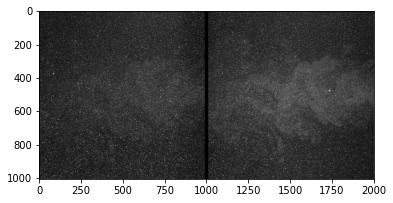

In [6]:
frame_a = imread('../test12/A001a.tif')
frame_b = imread('../test12/A001b.tif')
plt.imshow(np.c_[frame_a,np.ones((frame_a.shape[0],20)),frame_b],
             cmap=plt.cm.gray)

Found 44 bad peak(s)
Number of vectors: 3721
Number of large outliers: 221


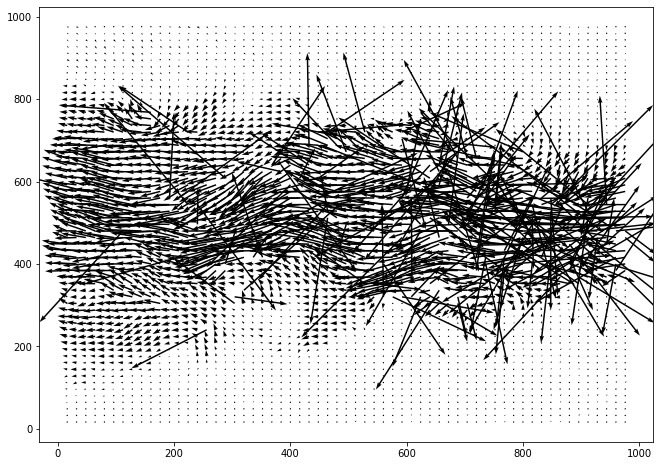

In [7]:
x, y, u, v = piv(frame_a, frame_b, [32, 32], [16, 16])
_,_, flag = local_median_val(u, v, 3, 3, 1)
print('Number of vectors: ' + str(u.size))
print('Number of large outliers: ' + str(len(flag[flag > 0])))
plt.figure(figsize = (11,8))
plt.quiver(x,y,u,v, scale = 80)

Found 9 bad peak(s)
Number of vectors: 6893
Number of large outliers: 117


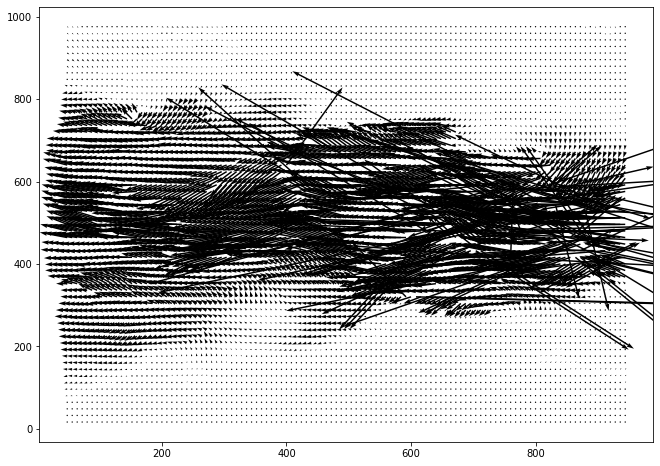

In [8]:
x, y, u, v = piv(frame_a, frame_b, [32, 96], [16, 88]) # [y, x], oversampled along x-axis
_,_, flag = local_median_val(u, v, 3, 3, 1)
print('Number of vectors: ' + str(u.size))
print('Number of large outliers: ' + str(len(flag[flag > 0])))
plt.figure(figsize = (11,8))
plt.quiver(x,y,u,v, scale = 80)